<a href="https://colab.research.google.com/github/quickscope42011/Python-and-deep-learing/blob/main/CNN_2D_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [ ]:
import time
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
import os
import natsort

from torch.utils.data import random_split,Dataset
from torch.utils.data.dataloader import DataLoader
from tqdm.auto import tqdm

# Hyperparameters

In [ ]:
epochs = 25
batch_size = 128
learning_rate = 0.001
opt_func = torch.optim.AdamW

# Data preprocessing

In [ ]:
current_dir = os.getcwd()
print(current_dir)

/content


In [ ]:
if not os.path.exists(current_dir + '/Trash Classified(12) - Student'):
  !gdown 13g9wTNbN9scWOUqQqZVpUx03k_RYd9VQ -O trash.zip
  !unzip -q trash.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper296.jpg  
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper297.jpg  
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper298.jpg  
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper299.jpg  
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper3.jpg  
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper30.jpg  
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper300.jpg  
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper301.jpg  
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper302.jpg  
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper303.jpg  
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper304.jpg  
  inflating: Trash Classified(12) - Student/Train_Dataset/paper/paper305.jpg  
  inflating: Trash Classified(12) 

In [ ]:
### Trash 12 ###
PATH1 = current_dir + '/Trash Classified(12) - Student/Test_Dataset'
PATH2 = current_dir + '/Trash Classified(12) - Student/Train_Dataset'
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(225),
    transforms.RandomCrop(200),
    transforms.RandomRotation(degrees = 15),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(225),
])

#test_ds = datasets.ImageFolder(root = PATH1, transform = transform)
dataset = datasets.ImageFolder(root = PATH2, transform = transform)

train_size = 13700
valid_size = len(dataset) - train_size
train_ds, valid_ds = random_split(dataset, [train_size, valid_size])

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True)
#test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle = True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Batch image shape: torch.Size([128, 3, 200, 200])
Batch label shape:  torch.Size([128])
torch.Size([3, 200, 200])
Image label: tensor(2)


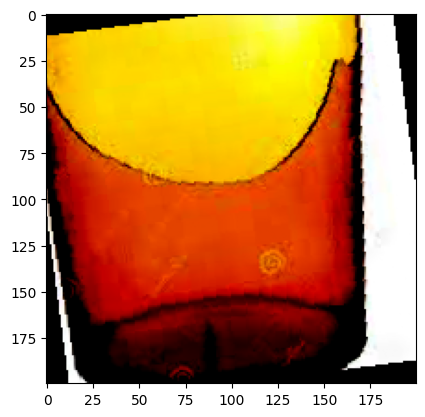

In [ ]:
for images, labels in train_dl:
    print('Batch image shape:' , images.shape)
    print('Batch label shape: ' , labels.shape)
    print(images[0].shape)
    img0 = torch.permute(images[0], (1,2,0))
    plt.imshow(img0)
    print('Image label:', labels[0])
    break

# Model

In [ ]:
# input dataloader size = [64, 3, 224, 224]

class Trash2DModel(torch.nn.Module):
  def __init__(self, n_out_classes = 12):
    super(Trash2DModel, self).__init__()
    
    self.model = nn.Sequential(
      
      ### convolution layer 1 ###

      nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(2, stride = 2),        # image_size = [floor(200 - 2 + 2*0) / 2 + 1] = 200

      ### convolution layer 2 ###

      nn.Conv2d(16, 32, kernel_size = 3, padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(2, stride = 2),
      
      # ### convolution layer 3 ###

      # nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
      # nn.ReLU(),
      # nn.BatchNorm2d(64),
      # nn.MaxPool2d(2, stride = 2),
      
      ### fully connected layer ###
      
      nn.Flatten(),
      nn.Linear(32*50*50, 128),
      nn.ReLU(),
      nn.BatchNorm1d(128),
      nn.Linear(128, n_out_classes)
    )

  def forward(self, x):
      x = self.model(x.float())
      return x

# CUDA

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_default_device()
print(device)

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    return len(self.dl)

cuda


In [ ]:
# model is first defined here
model_2D = to_device(Trash2DModel(), device)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
# test_dl  = DeviceDataLoader(test_dl, device)

# Metrics

In [ ]:
class calculate():
    def criterion(self, preds, labels): 
        labels = torch.reshape(labels, (-1,))
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        loss = F.cross_entropy(preds,labels)
        return loss

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
    def evaluate(self, val_loader):
        outputs = [self.validation_step(batch) for batch in val_loader]
        data = [output['data'] for output in outputs]
        return self.validation_average(outputs), data
    def print_all(self, epoch, result):
        print('Epoch [{}], train_loss: {:.6f}, train_acc: {:.6f}, val_loss:{:.6f}, val_acc:{:.6f}'.
        format(epoch, result['train_loss'][-1], result['train_accu'][-1],
        result['valid_loss'][-1], result['valid_accu'][-1]))

# Training process

In [ ]:
def training(train_dl, model, util):
    optimizer = opt_func(model.parameters(), learning_rate)
    model.train()
    batch_acc = []
    batch_loss = []
    for images, labels in tqdm(train_dl):
        
        outputs = model(images)
        loss = util.criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_loss.append(loss.clone().detach().cpu())
        batch_acc.append(util.accuracy(outputs, labels))
    return torch.stack(batch_loss).mean(), torch.stack(batch_acc).mean()

def validating(valid_dl, model, util):
    model.eval()
    batch_loss = [] 
    batch_acc = [] 
    for images, labels in tqdm(valid_dl):
        outputs = model(images)
        loss = util.criterion(outputs, labels)
        batch_loss.append(loss.clone().detach().cpu())
        batch_acc.append(util.accuracy(outputs, labels))
    return torch.stack(batch_loss).mean(), torch.stack(batch_acc).mean()

# Training result

In [ ]:
def fit(model, train_dl, val_dl, epochs, learning_rate):
    optimizer = opt_func(model.parameters(), learning_rate, weight_decay = 1e-5)
    util = calculate()
    results = {}
    results['train_loss'] = []
    results['train_accu'] = []
    results['valid_loss'] = []
    results['valid_accu'] = []
    for epoch in range(epochs):
        train_loss, train_accu = training(train_dl, model, util)
        valid_loss, valid_accu = validating(val_dl, model, util)
        results['train_loss'].append(train_loss)
        results['train_accu'].append(train_accu)
        results['valid_loss'].append(valid_loss)
        results['valid_accu'].append(valid_accu)
        util.print_all(epoch, results)
    return results

In [ ]:
ti = time.perf_counter()
results3d = fit(model_2D, train_dl, valid_dl, epochs, learning_rate)
te = time.perf_counter()

print('Time taken for training with {}: {:.2f}s'.format(device, te - ti))

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.391206, train_acc: 0.558087, val_loss:1.153671, val_acc:0.619901


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.120750, train_acc: 0.632668, val_loss:1.053397, val_acc:0.653220


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.985644, train_acc: 0.670139, val_loss:0.962611, val_acc:0.697095


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.887460, train_acc: 0.704427, val_loss:0.932915, val_acc:0.689258


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.854872, train_acc: 0.719835, val_loss:0.882560, val_acc:0.705534


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.779288, train_acc: 0.737992, val_loss:0.913258, val_acc:0.695373


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.745806, train_acc: 0.751591, val_loss:0.914812, val_acc:0.696675


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.706527, train_acc: 0.761719, val_loss:0.803744, val_acc:0.740307


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.722770, train_acc: 0.764757, val_loss:0.816027, val_acc:0.734691


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.662051, train_acc: 0.778067, val_loss:0.809689, val_acc:0.746538
Time taken for training with cuda: 1386.15s


# Save model

In [ ]:
torch.save(model_2D,current_dir+ '/w014.pth')     #save model

# Plot accuracy and loss

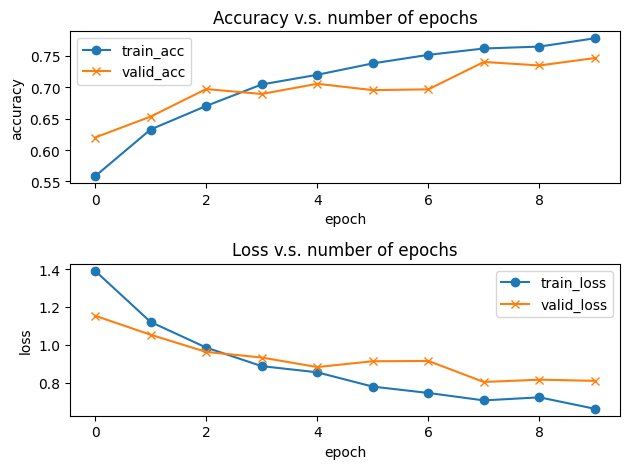

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(results3d['train_accu'], '-o', label = 'train_acc')
plt.plot(results3d['valid_accu'], '-x', label = 'valid_acc')
plt.xlabel('epoch'), plt.ylabel('accuracy')
plt.title('Accuracy v.s. number of epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(results3d['train_loss'], '-o', label = 'train_loss')
plt.plot(results3d['valid_loss'], '-x', label = 'valid_loss')
plt.xlabel('epoch'), plt.ylabel('loss')
plt.title('Loss v.s. number of epochs')
plt.legend()

plt.tight_layout()

# Prediction

In [ ]:
# define custom dataset class
class CustomDataSet(Dataset):
    def __init__(self, folder_dir, transform):
        self.folder_dir = folder_dir
        self.transform = transform
        all_imgs = os.listdir(folder_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.folder_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [ ]:
#configure preprocess steps
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(225),
    transforms.RandomCrop(200),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(225),
])
#create datast
pred_dataset = CustomDataSet(PATH1, transform=transform)
pred_loader = DataLoader(pred_dataset, pred_dataset.__len__())
pred_dl = DeviceDataLoader(pred_loader, device)

#load model
model = torch.load(current_dir+ '/w014.pth')

#use the loaded model to generate prediction results
pred_result = []
images = next(iter(pred_dl))
pred_output = model(images)
pred_probs = F.softmax(pred_output, dim=1)
pred_prob, pred_label = torch.max(pred_probs, dim=1)
pred_result.append(pred_label.tolist())

np.savetxt("p014.csv", pred_result, fmt = '%d')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# others